In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl


In [3]:
def calculate_mdx_mdy(x1, y1, z1, u2, v2, z2):
    
    # Calculate derivatives 
    d_x1 = d_y1 = z1 / 1000
    
    # Direction vectors of derivative ray
    d_vx_pp1 = u2 - (x1 + d_x1)
    d_vy_pp1 = v2 - (y1 + d_y1)
    vz_pp1 = z2 - z1
    d_v_mag = np.sqrt(d_vx_pp1**2 + d_vy_pp1**2 + vz_pp1**2)
    
    # And direction cosines
    d_M1_p = d_vy_pp1 / d_v_mag 
    d_L1_p = d_vx_pp1 / d_v_mag

    d_x2 = z2 * d_L1_p
    d_y2 = z2 * d_M1_p
    
    # To obtain derivative in magnification - which I don't know at all if it is correct. 
    mdx = d_x2 / d_x1
    mdy = d_y2 / d_y1
    
    return mdx, mdy

def calculate_principal_direction_cosines(x, y, z):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = 0.0 - x
    vy = 0.0 - y
    vz = 0.0 - z
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x0 - x1
    vy = y0 - y1
    vz = z0 - z1
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N
    
    


In [4]:
def fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If we want a lens that sends parallel rays to a focal plane perfectly, than we have to 
    # set the object distance z1 to an arbitrarily large, but not infinite value, and 
    # define a new small magnification value
    if np.abs(m_p) < 1e-10:
        y1_old = y1
        z1 = -1e10
        m_p = z2 / z1
        L1_p, M1_p, N1_p = calculate_principal_direction_cosines(x1, y1, z1)
        L1, M1, N1  = calculate_direction_cosines(x1, y1, z1)
        
    else:
        L1_p, M1_p, N1_p = calculate_principal_direction_cosines(x1, y1, z1)
        

    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        
        mdx, mdy = calculate_mdx_mdy(x1, y1, z1, z2)

        # Obtain coordinates in image plane
        x2 = z2 * L1
        y2 = z2 * M1
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = x2 / rp
        M2_p = y2 / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        
        if fourier_lens:
            L2_p = x1 / z1
            M2_p = y1 / z1
            N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, z2)
            
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1_p + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

In [5]:
def perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If we want a lens that sends parallel rays to a focal plane perfectly, than we have to 
    # set the object distance z1 to an arbitrarily large, but not infinite value, and 
    # define a new small magnification value
    if np.abs(m_p) < 1e-10:
        # y1_old = y1
        # z1_old = z1
        # z1 = -1e10
        # y1 = (M1 / N1) * (z1 - z1_old) + y1_old
        # m_p = z2 / z1
        # L1_p, M1_p, N1_p = L1, M1, N1
        # L1, M1, N1  = calculate_direction_cosines(x1, y1_old, z1, u1, v1, 0)
        L1_p, M1_p, N1_p = L1, M1, N1
    else:
        L1_p, M1_p, N1_p = calculate_principal_direction_cosines(x1, y1, z1)
        

    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        
        # Obtain coordinates in image plane
        x2 = z2 * L1_p / N1_p
        y2 = z2 * M1_p / N1_p
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = x2 / rp
        M2_p = y2 / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        
        a = x1 / z1
        b = y1 / z1
        N2_p = np.sqrt(1 - a ** 2 - b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2

    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p

    L2 = (L1 + Cx) / mdx
    
    # R = np.sqrt((0.0 - y2) ** 2 + (0.0 - x2) ** 2)
    # y_circ = -np.sqrt(R**2 - (0.0 - z2) ** 2) + y2
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

In [6]:
def perfect_lens_coords(x1, y1, z1, vx1, vy1, vz1, z2, f, m_p, fourier_lens = 0.0):

    # If we want a lens that sends parallel rays to a focal plane perfectly, than we have to 
    # set the object distance z1 to an arbitrarily large, but not infinite value, and 
    # define a new small magnification value
    if np.abs(m_p) < 1e-10:
        z1 = -1e10
        m_p = z2 / z1
    
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx_pp1 = 0.0 - x1
    vy_pp1 = 0.0 - y1
    vz_pp1 = 0.0 - z1
    v_mag = np.sqrt(vx_pp1**2 + vy_pp1**2 + vz_pp1**2)
    
    # And it's direction cosines
    M1_p = vy_pp1 / v_mag 
    L1_p = vx_pp1 / v_mag
    N1_p = vz_pp1 / v_mag #np.sqrt(1 - L1_p ** 2 - M1_p ** 2)
    
    #Then, calculate the direction cosines of the incident ray
    v1_mag = np.sqrt(vx1**2 + vy1**2 + vz1**2)
    
    L1 = vx1 / v1_mag # x direction cosine
    M1 = vy1 / v1_mag # y direction cosine
    N1 = np.sqrt(1 - L1 **2 - M1 ** 2) #z direction cosine
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        
        if fourier_lens:
            # Fourier lens uses sin of angle between principal ray direction and focal plane
            # which equates to using L1_p, M1_p as the direction vectors to find the point where
            # principal plane goes through back focal plane.
            direction_1p_x = L1_p
            direction_1p_y = M1_p
        else:
            # Paraxial lens uses tan of angle between principal ray direction and focal plane
            # which equates to using L1_p / N1_p, M1_p / N1_p as the direction vectors to find the point where
            # principal plane goes through back focal plane.
            direction_1p_x = (L1_p / N1_p)
            direction_1p_y = (M1_p / N1_p)
        
        # Obtain coordinates in image plane
        x2 = z2 * direction_1p_x
        y2 = z2 * direction_1p_y
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines principal ray from lens to image point
        L2_p = x2 / rp
        M2_p = y2 / rp
        
        if fourier_lens:
            # Fourier lens also uses a "derivative magnification" term to satisfy 
            # Abbe's sine law. I have interpreted a lot of this trying to fill in gaps from the paper, 
            # so not sure if what I have done is right at all . 
            # See page 1114 in the article, top right column for where I got the idea from to
            # calculate dx2 and dy2 from this. This is why reading the code might be helpful
            
            # Calculate derivatives 
            dx1 = dy1 = z1 / 1000
            dvx_pp1 = 0.0 - (x1 + dx1)
            dvy_pp1 = 0.0 - (y1 + dy1)
            dv_mag = np.sqrt(dvx_pp1**2 + dvy_pp1**2 + vz_pp1**2)
    
            # And it's direction cosines
            dM1_p = dvy_pp1 / dv_mag 
            dL1_p = dvx_pp1 / dv_mag
            dN1_p = np.sqrt(1 - dL1_p ** 2 - dM1_p ** 2)

            ddirection_1p_x = dL1_p
            ddirection_1p_y = dM1_p
            
            dx2 = z2 * ddirection_1p_x
            dy2 = z2 * ddirection_1p_y
            
            # To obtain derivative in magnification - which I don't know at all if it is correct. 
            mdx = dx2 / dx1
            mdy = dy2 / dy1
        else: 
            mdx = mdy = m_p
        
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        # Calculate positions where the ray crosses the front and back focal plane. 
        x1_hat = - f * L2_p / N2_p
        y1_hat = - f * M2_p / N2_p
        
        x2_hat = f * direction_1p_x
        y2_hat = f * direction_1p_y
    
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        
        if fourier_lens:
            L2_p = x1 / z1
            M2_p = y1 / z1
            N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
            # Again unsure of what to do about mdx. 
            mdy = m_p * (1 - (M1 ** 2))
            mdx = m_p
            
        else:
            a = x1 / z1
            b = y1 / z1
            
            N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
            L2_p = a * N2_p
            M2_p = b * N2_p
            
            mdx = mdy = m_p
            
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        
        x1_hat = - f * (L1_p / N1_p)
        y1_hat = - f * (M1_p / N1_p)
        
        x2_hat = f * (L2_p / N2_p)
        y2_hat = f * (M2_p / N2_p)
    

        
    return x2, y2, u1, v1, u2, v2, x1_hat, y1_hat, x2_hat, y2_hat

In [19]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -1e-11
f = 5

if np.abs(m_p) < 1e-10:
    z1 = -1e10
    z2 = f
    m_p = z2 / z1
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 1

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(4, 4, N)
z1 = np.linspace(-5, -5, N)

# vx1 = np.linspace(0, 0, N)
# vy1 = np.linspace(0.1, 0.1, N)
# vz1 = 1.0

# #Then, calculate the direction cosines of the incident ray
# v1_mag = np.sqrt(vx1**2 + vy1**2 + vz1**2)

angles = np.linspace(0.5, 0.5, N)
L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction 


x2, y2, u1, v1, u2, v2 = perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

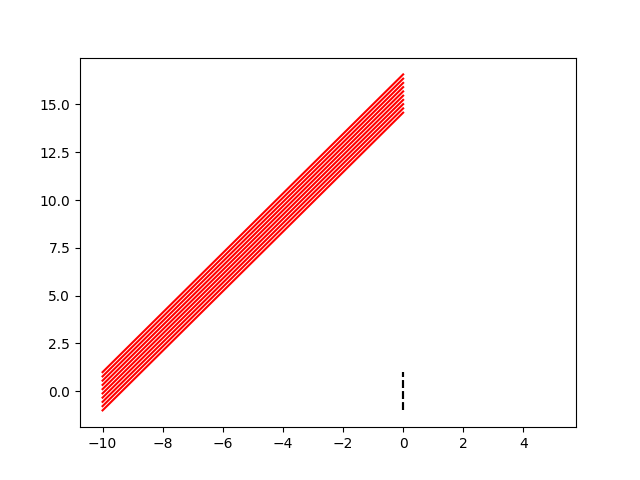

In [8]:
plt.figure()
plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

# plt.plot([z1s + pp_1s, pp_1s], [y1, np.zeros(y1.shape)], '-k')
plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-r')
plt.plot([], [], '-r', label = 'Perfect Lens')
# plt.plot([pp_2s, z2s + pp_2s], [np.zeros(y1.shape), y2], '-k')
plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-r')
# plt.axis('equal')


Perhaps the best thing to do is this much simpler version of the fourier lens, where we basically just use simple sin and tan operations to achieve the same behaviour? It will be faster to calculate. 

-0.47942553825316997


(-5.5, 5.5, -0.5, 10.5)

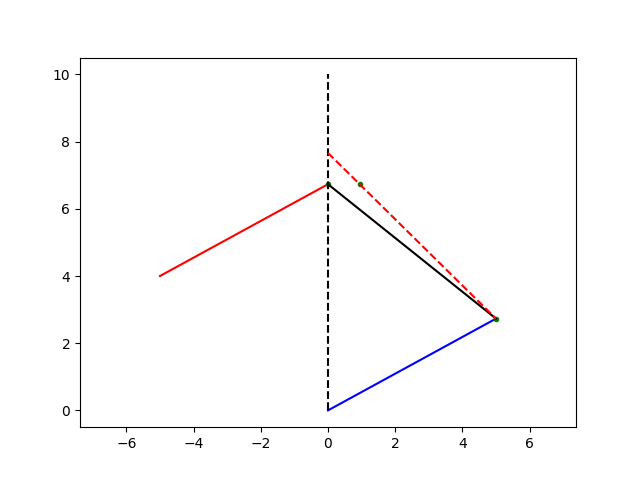

In [15]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -1e-11
f = 5

if np.abs(m_p) < 1e-10:
    
    z1 = -1e10
    z2 = f
    m_p = z2 / z1
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)


N = 1

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = 4
z1s = z1
z2s = z2

theta = 0.5
angles = theta
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - M1 ** 2) #z direction 
M1_p, N1_p = M1, N1

y2 = z2 * M1_p / N1_p
rp = np.sqrt(y2 **2 + z2 ** 2)
M2_p = y2 / rp
N2_p = np.sqrt(1 - M2_p ** 2)

v1 = - (M1 / N1) * z1s + y1
y2_hat_sin = y2_sin = f * np.sin(theta)
y2_hat_tan = y2_tan = f * np.tan(theta)
zls = lens_z

R2 = np.sqrt(f ** 2 + y2_hat_tan ** 2)
z_circ = -np.sqrt(R2**2 - (v1 - y2_tan) ** 2) + z2

vy_2 = y2_tan - v1
vz_2 = z2 - z_circ
v2_mag = np.sqrt((vy_2) ** 2 + (vz_2) ** 2)
M2 = vy_2 / v2_mag
N2 = vz_2 / v2_mag
v2 = - (M2 / N2) * z2 + y2_tan

Cy = (M2 * m_p) - M1


plt.figure()
plt.plot([z1s, zls], [y1, v1], '-r')
plt.plot([zls, z2s], [np.zeros(y2_tan.shape), y2_tan], '-b')
plt.plot(z2, y2_tan, '.g')
plt.plot(z_circ, v1, '.g')
plt.plot(0, v1, '.g')
plt.vlines(lens_z, 0, 10, linestyle = '--', color = 'k')
plt.plot([0, z2], [v1, y2_tan], '-k')
plt.plot([0, z2], [v2, y2_tan], '--r')
plt.axis('equal')

print(Cy)